In [805]:
import numpy as np


# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
#from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from scipy.spatial import distance
from scipy.linalg import norm
from scipy.spatial.distance import euclidean
# Loading your IBM Quantum account(s)
#provider = IBMQ.load_account()
import matplotlib.pyplot as plt
import pandas as pd

In [806]:
# error probabilties, I took the following value randomly
#wondering should I take them randomly
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.providers.aer import AerSimulator
from qiskit.tools.visualization import plot_histogram

# Import from Qiskit Aer noise module
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error


reset_error = 0.05 # this acts on single qubit gate, probability of flip a singe qubit P(reset)
measure_error = 0.2 # P(measure error)
gate_error = 0.05 # P(two qubit error)

# calling error functions using from IBM library
re_err = pauli_error([('X', reset_error),('I',1-reset_error)])
meas_err = pauli_error([('X', measure_error),('I', 1-measure_error)])
gate_err1 = pauli_error([('X', gate_error),('I', 1-gate_error)])
gate_err2 = gate_err1.tensor(gate_err1)

# errors on a noisy model
bitflip_err = NoiseModel()
bitflip_err.add_all_qubit_quantum_error(re_err,"reset")
bitflip_err.add_all_qubit_quantum_error(meas_err,"measure")
bitflip_err.add_all_qubit_quantum_error(gate_err1,["u1", "u2", "u3"])
bitflip_err.add_all_qubit_quantum_error(gate_err2, "cx")

print(bitflip_err)



NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['cx', 'measure', 'u3', 'u1', 'u2', 'reset']
  All-qubits errors: ['reset', 'measure', 'u1', 'u2', 'u3', 'cx']


In [807]:
def generate_plot(ideal_counts, calculated_counts, error_name, circ_name):
    # Match both dictionaries key 
    for key in calculated_counts:
        if key not in ideal_counts:
            ideal_counts[key] = 0
    
    for key in ideal_counts:
        if key not in calculated_counts:
            calculated_counts[key] = 0
            
    ideal_counts = dict(sorted(ideal_counts.items()))
    calculated_counts = dict(sorted(calculated_counts.items()))
    
    #Probability Distribution
    s_ideal = sum(ideal_counts.values())
    for key, value in ideal_counts.items():
        percentage = value / s_ideal
        ideal_counts[key] = percentage
        
    s_calculated = sum(calculated_counts.values())
    for key, value in calculated_counts.items():
        percentage = value / s_calculated
        calculated_counts[key] = percentage
    
    fname = f'./Images/Bar_charts/{error_name}_{circ_name}.pdf'
        
    X = np.arange(len(calculated_counts))
    f, ax = plt.subplots(figsize=(10,6))
    ax.bar(X-0.2, calculated_counts.values(), width=0.4, color='b', align='center')
    ax.bar(X+0.2, ideal_counts.values(), width=0.4, color='g', align='center')
    ax.legend(('Calculated Probability','Ideal Probability'))
    plt.xticks(X, calculated_counts.keys())
    plt.xticks(X, ideal_counts.keys())
    plt.xticks(rotation=90)
    plt.xlabel("States")
    plt.ylabel("Probability")
    plt.savefig(fname)
    plt.show()

In [808]:
def bit_error(circ, qubits, circ_name):
    import numpy as np
    from qiskit import QuantumCircuit, transpile
    from qiskit.quantum_info import Kraus, SuperOp
    from qiskit.providers.aer import AerSimulator
    from qiskit.tools.visualization import plot_histogram

    # Import from Qiskit Aer noise module
    from qiskit.providers.aer.noise import NoiseModel
    from qiskit.providers.aer.noise import QuantumError, ReadoutError
    from qiskit.providers.aer.noise import pauli_error
    from qiskit.providers.aer.noise import depolarizing_error
    from qiskit.providers.aer.noise import thermal_relaxation_error


    reset_error = 0.05 # this acts on single qubit gate, probability of flip a singe qubit P(reset)
    measure_error = 0.2 # P(measure error)
    gate_error = 0.05 # P(two qubit error)

    # calling error functions using from IBM library
    re_err = pauli_error([('X', reset_error),('I',1-reset_error)])
    meas_err = pauli_error([('X', measure_error),('I', 1-measure_error)])
    gate_err1 = pauli_error([('X', gate_error),('I', 1-gate_error)])
    gate_err2 = gate_err1.tensor(gate_err1)

    # errors on a noisy model
    bitflip_err = NoiseModel()
    bitflip_err.add_all_qubit_quantum_error(re_err,"reset")
    bitflip_err.add_all_qubit_quantum_error(meas_err,"measure")
    bitflip_err.add_all_qubit_quantum_error(gate_err1,["u1", "u2", "u3"])
    bitflip_err.add_all_qubit_quantum_error(gate_err2, "cx")
    
    ideal_sim = AerSimulator()
    ideal_result = ideal_sim.run(circ).result()
    ideal_counts = ideal_result.get_counts()
    
    sim_noise = AerSimulator(noise_model=bitflip_err)
    
    tnoise = transpile(circ, sim_noise)
    result_bit_flip = sim_noise.run(tnoise).result()
    counts_bit_flip = result_bit_flip.get_counts()

    legend = ['ideal', 'bit_flip']

    # Plot noisy output
    
    generate_plot(ideal_counts, counts_bit_flip, 'bit_error', circ_name)
    
    num_binary_states = 2**qubits

    # get the total counts for two dictionaries
    N1 = sum(ideal_counts.values())
    N2 = sum(counts_bit_flip.values())

    # add missing binary states in both distributions
    # example, dist1 = {'0': 400} and dist2 = {'1': 600}
    # the follwoing for loop will make them both same size (i.e., with same keys)
    # new dist1 = {'0': 400, '1': 0} and dist2 = {'0': 0, '1': 600}
    for number in range(2**qubits):
        # following line converts an integer to a binary string 
        # the binary string length is fixed and it is number of qubits
        # example, if number of qubit is 4, integer 3 will be `0011`
        binary_state = '{0:b}'.format(number).zfill(qubits)

        if binary_state not in ideal_counts:
            ideal_counts[binary_state] = 0
        
        if binary_state not in counts_bit_flip:
            counts_bit_flip[binary_state] = 0

    # following loop actually computes the TVD between two distributions
    tvd = 0
    print(' TVD Distribution')
    for key in ideal_counts:
        print(key)
        print(ideal_counts[key], counts_bit_flip[key])
        tvd = tvd + 0.5 * abs(ideal_counts[key]/N1 - counts_bit_flip[key]/N2)
        print(tvd)
    
    
    print('Jensen-Shannon Distance')
    from scipy.spatial import distance
    a = ideal_counts.values()
    b = counts_bit_flip.values()
    data_a = list(a)
    data_b = list(b)
    arr_a = np.array(data_a)
    arr_b = np.array(data_b)
    jsd = distance.jensenshannon(arr_a, arr_b)
    print(jsd)
    
    print('Hellinger Distance') 
    _SQRT2 = np.sqrt(2)
    hell1 = norm(np.sqrt(arr_a) - np.sqrt(arr_b)) / _SQRT2
    print(hell1)
    hell2 = euclidean(np.sqrt(arr_a), np.sqrt(arr_b)) / _SQRT2
    print(hell2)
    hell3 = np.sqrt(np.sum((np.sqrt(arr_a) - np.sqrt(arr_b)) ** 2)) / _SQRT2
    print(hell3)
    
    return tvd, jsd, hell1, hell2, hell3

def ideal(circ):
    
    ideal_sim = AerSimulator()
    ideal_result = ideal_sim.run(circ).result()
    ideal_counts = ideal_result.get_counts()

    
    return ideal_counts, ideal_counts, counts_bit_flip

In [809]:
# GHZ gate
q_ghz = QuantumRegister(3)
c_ghz = ClassicalRegister(3)
ghz_circ = QuantumCircuit(q_ghz, c_ghz)
ghz_circ.h(q_ghz[0])
ghz_circ.cx(q_ghz[0], q_ghz[1])
ghz_circ.cx(q_ghz[1], q_ghz[2])
ghz_circ.measure(q_ghz[0:3], c_ghz[0:3])
ghz_circ.draw()

┌───┐          ┌─┐      
q5960_0: ┤ H ├──■───────┤M├──────
         └───┘┌─┴─┐     └╥┘┌─┐   
q5960_1: ─────┤ X ├──■───╫─┤M├───
              └───┘┌─┴─┐ ║ └╥┘┌─┐
q5960_2: ──────────┤ X ├─╫──╫─┤M├
                   └───┘ ║  ║ └╥┘
 c126: 3/════════════════╩══╩══╩═
                         0  1  2

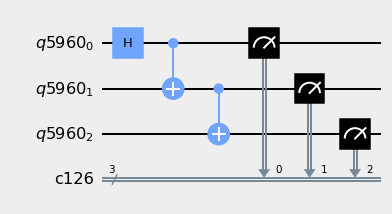

In [810]:
circuit_drawer(ghz_circ, output='mpl', style={'backgroundcolor': '#EEEEEE'}, filename='./Images/Circuits/ghz_circ.pdf')

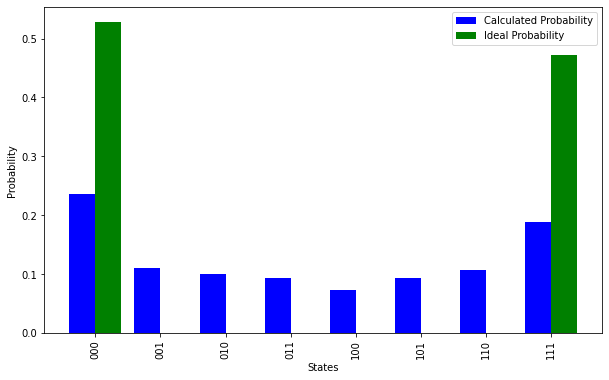

 TVD Distribution
111
483 192
0.14208984375
000
541 241
0.28857421875
101
0 96
0.33544921875
001
0 112
0.39013671875
110
0 109
0.443359375
100
0 75
0.47998046875
011
0 96
0.52685546875
010
0 103
0.5771484375
Jensen-Shannon Distance
0.6481036789038382
Hellinger Distance
23.717362323509683
23.717362323509683
23.717362323509683


(0.5771484375,
 0.6481036789038382,
 23.717362323509683,
 23.717362323509683,
 23.717362323509683)

In [811]:
bit_error(ghz_circ, len(q_ghz), 'ghz_circ')

In [812]:
def t1_t2(qubits, circ, circ_name):
    # T1 and T2 values for qubits 0-3
    T1s = np.random.normal(50e3, 10e3, qubits) # Sampled from normal distribution mean 50 microsec
    T2s = np.random.normal(70e3, 10e3, qubits)  # Sampled from normal distribution mean 50 microsec

# Truncate random T2s <= T1s
    T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(qubits)])

# Instruction times (in nanoseconds)
    time_u1 = 0   # virtual gate
    time_u2 = 50  # (single X90 pulse)
    time_u3 = 100 # (two X90 pulses)
    time_cx = 300
    time_reset = 1000  # 1 microsecond
    time_measure = 1000 # 1 microsecond

# QuantumError objects
    errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                for t1, t2 in zip(T1s, T2s)]
    errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                  for t1, t2 in zip(T1s, T2s)]
    errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
              for t1, t2 in zip(T1s, T2s)]
    errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
              for t1, t2 in zip(T1s, T2s)]
    errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
              for t1, t2 in zip(T1s, T2s)]
    errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
             thermal_relaxation_error(t1b, t2b, time_cx))
              for t1a, t2a in zip(T1s, T2s)]
               for t1b, t2b in zip(T1s, T2s)]

# Add errors to noise model
    noise_thermal = NoiseModel()
    for j in range(qubits):
        noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
        noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
        noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
        noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
        noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
        for k in range(3):
            noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])
    
    
    ideal_sim = AerSimulator()
    ideal_result = ideal_sim.run(circ).result()
    ideal_counts = ideal_result.get_counts()
    
    sim_noise = AerSimulator(noise_model=bitflip_err)
    
    tnoise = transpile(circ, sim_noise)
    result_bit_flip = sim_noise.run(tnoise).result()
    counts_bit_flip = result_bit_flip.get_counts()
    
    
    # Run the noisy simulation
    sim_thermal = AerSimulator(noise_model=noise_thermal)

    # Transpile circuit for noisy basis gates
    tthermal = transpile(circ, sim_thermal)

    # Run and get counts
    result_thermal = sim_thermal.run(tthermal).result()
    counts_thermal = result_thermal.get_counts()
    legend_t = ['ideal', 'thermal']

    # Plot noisy output
    generate_plot(ideal_counts, counts_thermal, 't1_t2', circ_name)
    
    
    num_binary_states = 2**qubits

    # get the total counts for two dictionaries
    N1 = sum(ideal_counts.values())
    N2 = sum(counts_bit_flip.values())

    # add missing binary states in both distributions
    # example, dist1 = {'0': 400} and dist2 = {'1': 600}
    # the follwoing for loop will make them both same size (i.e., with same keys)
    # new dist1 = {'0': 400, '1': 0} and dist2 = {'0': 0, '1': 600}
    for number in range(2**qubits):
        # following line converts an integer to a binary string 
        # the binary string length is fixed and it is number of qubits
        # example, if number of qubit is 4, integer 3 will be `0011`
        binary_state = '{0:b}'.format(number).zfill(qubits)

        if binary_state not in ideal_counts:
            ideal_counts[binary_state] = 0
        
        if binary_state not in counts_thermal:
            counts_thermal[binary_state] = 0

    # following loop actually computes the TVD between two distributions
    tvd = 0
    print('TVD Distribution')
    for key in ideal_counts:
        print(key)
        print(ideal_counts[key], counts_bit_flip[key])
        tvd = tvd + 0.5 * abs(ideal_counts[key]/N1 - counts_thermal[key]/N2)
        print(tvd)
        
        
    print('Jensen-Shannon Distance')
    from scipy.spatial import distance
    a = ideal_counts.values()
    b = counts_thermal.values()
    data_a = list(a)
    data_b = list(b)
    arr_a = np.array(data_a)
    arr_b = np.array(data_b)
    jsd = distance.jensenshannon(arr_a, arr_b)
    print(jsd)
    
    print('Hellinger Distance') 
    _SQRT2 = np.sqrt(2)
    hell1 = norm(np.sqrt(arr_a) - np.sqrt(arr_b)) / _SQRT2
    print(hell1)
    hell2 = euclidean(np.sqrt(arr_a), np.sqrt(arr_b)) / _SQRT2
    print(hell2)
    hell3 = np.sqrt(np.sum((np.sqrt(arr_a) - np.sqrt(arr_b)) ** 2)) / _SQRT2
    print(hell3)
    
    return tvd, jsd, hell1, hell2, hell3

    

In [813]:
def depolar(qubits, circ, circ_name):

    p_gate = 0.1
    error_meas = pauli_error([('X',reset_error), ('I', 1 - reset_error)])
    error_gate1 = depolarizing_error(p_gate, qubits)
    error_gate2 = error_gate1.tensor(error_gate1)

    noise_depolar = NoiseModel()
    noise_depolar.add_all_qubit_quantum_error(error_meas, "measure", qubits)
    
    
    ideal_sim = AerSimulator()
    ideal_result = ideal_sim.run(circ).result()
    ideal_counts = ideal_result.get_counts()
    
    sim_noise = AerSimulator(noise_model=bitflip_err)
    
    tnoise = transpile(circ, sim_noise)
    result_bit_flip = sim_noise.run(tnoise).result()
    counts_bit_flip = result_bit_flip.get_counts()

    # Run the noisy simulation
    sim_depolar = AerSimulator(noise_model=noise_depolar)

    # Transpile circuit for noisy basis gates
    depolar = transpile(circ, sim_depolar)

    # Run and get counts
    result_depolar = sim_depolar.run(depolar).result()
    counts_depolar = result_depolar.get_counts()
    legend_t = ['ideal', 'depolar']

    # Plot noisy output
    generate_plot(ideal_counts, counts_depolar, 'depolar', circ_name)
    
    num_binary_states = 2**qubits

    # get the total counts for two dictionaries
    N1 = sum(ideal_counts.values())
    N2 = sum(counts_bit_flip.values())

    # add missing binary states in both distributions
    # example, dist1 = {'0': 400} and dist2 = {'1': 600}
    # the follwoing for loop will make them both same size (i.e., with same keys)
    # new dist1 = {'0': 400, '1': 0} and dist2 = {'0': 0, '1': 600}
    for number in range(2**qubits):
        # following line converts an integer to a binary string 
        # the binary string length is fixed and it is number of qubits
        # example, if number of qubit is 4, integer 3 will be `0011`
        binary_state = '{0:b}'.format(number).zfill(qubits)

        if binary_state not in ideal_counts:
            ideal_counts[binary_state] = 0
        
        if binary_state not in counts_bit_flip:
            counts_bit_flip[binary_state] = 0

    # following loop actually computes the TVD between two distributions
    tvd = 0
    print('TVD Distribution')
    for key in ideal_counts:
        print(key)
        print(ideal_counts[key], counts_bit_flip[key])
        tvd = tvd + 0.5 * abs(ideal_counts[key]/N1 - counts_bit_flip[key]/N2)
        print(tvd)
    
    
    print('Jensen-Shannon Distance')
    from scipy.spatial import distance
    a = ideal_counts.values()
    b = counts_bit_flip.values()
    data_a = list(a)
    data_b = list(b)
    arr_a = np.array(data_a)
    arr_b = np.array(data_b)
    jsd = distance.jensenshannon(arr_a, arr_b)
    print(jsd)
    
    print('Hellinger Distance') 
    _SQRT2 = np.sqrt(2)
    hell1 = norm(np.sqrt(arr_a) - np.sqrt(arr_b)) / _SQRT2
    print(hell1)
    hell2 = euclidean(np.sqrt(arr_a), np.sqrt(arr_b)) / _SQRT2
    print(hell2)
    hell3 = np.sqrt(np.sum((np.sqrt(arr_a) - np.sqrt(arr_b)) ** 2)) / _SQRT2
    print(hell3)
                              
    
    return tvd, jsd, hell1, hell2, hell3

In [814]:
def tvd_calculator(dist_1, dist_2, num_qubits):
    """This function accepts two counts distributions as dictionaries
    and computes the total variation distribution (TVD) between them

    Args:
        dist1 & dist2: counts dictionary from IBM backend/simulator.
               example, {'00': 4000, '01': 4192}
        num_qubits: number of measured qubits in the qunatum circuits.

    Returns:
        tvd: Total variation distribution between two distributions
    """
    num_binary_states = 2**num_qubits

    # get the total counts for two dictionaries
    N1 = sum(dist_1.values())
    N2 = sum(dist_2.values())

    # add missing binary states in both distributions
    # example, dist1 = {'0': 400} and dist2 = {'1': 600}
    # the follwoing for loop will make them both same size (i.e., with same keys)
    # new dist1 = {'0': 400, '1': 0} and dist2 = {'0': 0, '1': 600}
    for number in range(2**num_qubits):
        # following line converts an integer to a binary string 
        # the binary string length is fixed and it is number of qubits
        # example, if number of qubit is 4, integer 3 will be `0011`
        binary_state = '{0:b}'.format(number).zfill(num_qubits)

        if binary_state not in dist_1:
            dist_1[binary_state] = 0
        
        if binary_state not in dist_2:
            dist_2[binary_state] = 0

    # following loop actually computes the TVD between two distributions
    tvd = 0
    for key in dist_1:
        print(dist_1[key], dist_2[key])
        tvd = tvd + 0.5 * abs(dist_1[key]/N1 - dist_2[key]/N2)

    return tvd


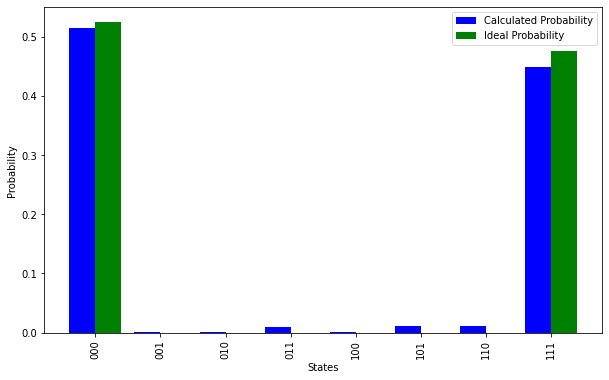

TVD Distribution
111
487 222
0.01318359375
000
537 225
0.01806640625
001
0 106
0.01904296875
010
0 114
0.01953125
101
0 98
0.02490234375
011
0 84
0.02978515625
110
0 78
0.03564453125
100
0 97
0.0361328125
Jensen-Shannon Distance
0.8265858816754696
Hellinger Distance
31.138686010794235
31.138686010794235
31.138686010794235


(0.0361328125,
 0.8265858816754696,
 31.138686010794235,
 31.138686010794235,
 31.138686010794235)

In [815]:
t1_t2(len(q_ghz), ghz_circ, 'ghz_circ')

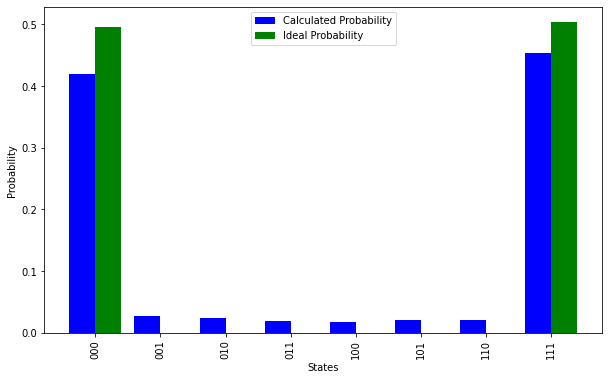

TVD Distribution
000
508 243
0.12939453125
111
516 234
0.26708984375
010
0 73
0.302734375
001
0 97
0.35009765625
101
0 93
0.3955078125
011
0 87
0.43798828125
110
0 116
0.49462890625
100
0 81
0.5341796875
Jensen-Shannon Distance
0.6564050473724145
Hellinger Distance
24.01031951085841
24.01031951085841
24.01031951085841


(0.5341796875,
 0.6564050473724145,
 24.01031951085841,
 24.01031951085841,
 24.01031951085841)

In [816]:
depolar(len(q_ghz), ghz_circ, 'ghz_circ')

In [817]:
#Mermin_Bell gate
from math import pi
mer_bell = QuantumRegister(3)
mer_bell_c =  ClassicalRegister(3)
mer_bell_circ = QuantumCircuit(mer_bell, mer_bell_c)
mer_bell_circ.rx(-pi/2, mer_bell[0])
mer_bell_circ.cx(mer_bell[0], mer_bell[1])
mer_bell_circ.cx(mer_bell[1], mer_bell[2])
mer_bell_circ.h(mer_bell[1])
mer_bell_circ.h(mer_bell[2])
mer_bell_circ.cx(mer_bell[0], mer_bell[2])
mer_bell_circ.cx(mer_bell[1], mer_bell[2])
mer_bell_circ.cx(mer_bell[2], mer_bell[0])
mer_bell_circ.cx(mer_bell[1], mer_bell[0])
mer_bell_circ.s(mer_bell[2])
mer_bell_circ.s(mer_bell[0])
mer_bell_circ.h(mer_bell[2])
mer_bell_circ.cz(mer_bell[0], mer_bell[1])
mer_bell_circ.h(mer_bell[0])
mer_bell_circ.s(mer_bell[1])
mer_bell_circ.h(mer_bell[1])
mer_bell_circ.measure(mer_bell[0:3], mer_bell_c[0:3])
display(mer_bell_circ.draw())
                           

┌──────────┐                         ┌───┐┌───┐┌───┐   ┌───┐     ┌─┐»
q6002_0: ┤ Rx(-π/2) ├──■──────────────■───────┤ X ├┤ X ├┤ S ├─■─┤ H ├─────┤M├»
         └──────────┘┌─┴─┐     ┌───┐  │       └─┬─┘└─┬─┘└───┘ │ ├───┤┌───┐└╥┘»
q6002_1: ────────────┤ X ├──■──┤ H ├──┼────■────┼────■────────■─┤ S ├┤ H ├─╫─»
                     └───┘┌─┴─┐├───┤┌─┴─┐┌─┴─┐  │  ┌───┐┌───┐┌─┐└───┘└───┘ ║ »
q6002_2: ─────────────────┤ X ├┤ H ├┤ X ├┤ X ├──■──┤ S ├┤ H ├┤M├───────────╫─»
                          └───┘└───┘└───┘└───┘     └───┘└───┘└╥┘           ║ »
 c127: 3/═════════════════════════════════════════════════════╩════════════╩═»
                                                              2            0 »
«            
«q6002_0: ───
«         ┌─┐
«q6002_1: ┤M├
«         └╥┘
«q6002_2: ─╫─
«          ║ 
« c127: 3/═╩═
«          1

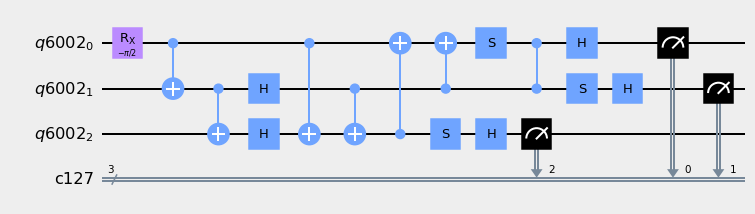

In [818]:
circuit_drawer(mer_bell_circ, output='mpl', style={'backgroundcolor': '#EEEEEE'}, filename='./Images/Circuits/mer_bell_circ.pdf')

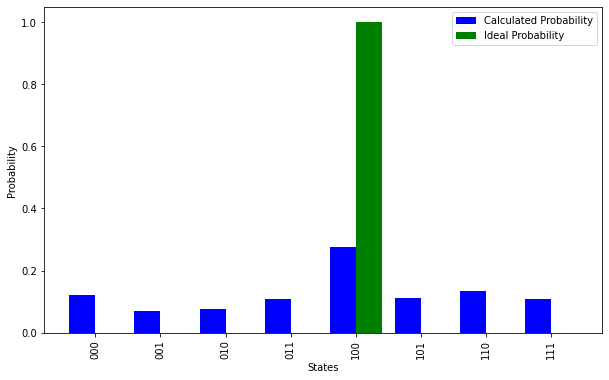

 TVD Distribution
100
1024 281
0.36279296875
001
0 71
0.3974609375
101
0 114
0.453125
010
0 78
0.4912109375
110
0 136
0.5576171875
011
0 110
0.611328125
111
0 110
0.6650390625
000
0 124
0.7255859375
Jensen-Shannon Distance
0.751520193626742
Hellinger Distance
27.465673253323985
27.465673253323985
27.465673253323985


(0.7255859375,
 0.751520193626742,
 27.465673253323985,
 27.465673253323985,
 27.465673253323985)

In [819]:
bit_error(mer_bell_circ, len(mer_bell), 'mermin_circ')

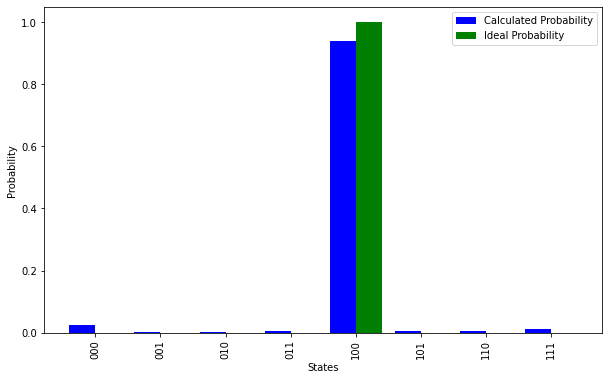

TVD Distribution
100
1024 279
0.02978515625
001
0 70
0.0302734375
010
0 83
0.03125
110
0 144
0.03466796875
000
0 104
0.04736328125
011
0 101
0.05078125
111
0 130
0.05712890625
101
0 113
0.0595703125
Jensen-Shannon Distance
0.8302253629294643
Hellinger Distance
31.49603149604724
31.49603149604724
31.49603149604724


(0.0595703125,
 0.8302253629294643,
 31.49603149604724,
 31.49603149604724,
 31.49603149604724)

In [820]:
t1_t2(len(mer_bell), mer_bell_circ, 'mermin_circ')

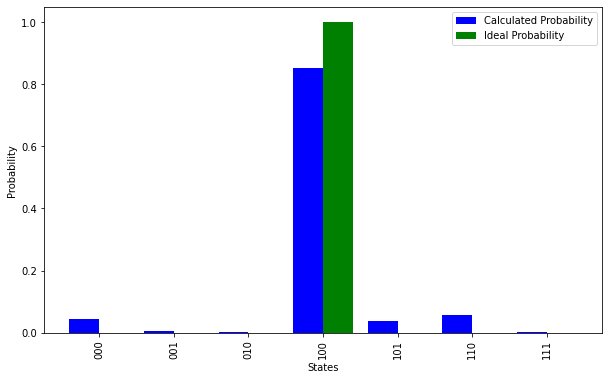

TVD Distribution
100
1024 253
0.37646484375
010
0 83
0.4169921875
101
0 118
0.474609375
001
0 86
0.5166015625
110
0 157
0.59326171875
000
0 104
0.64404296875
111
0 112
0.69873046875
011
0 111
0.7529296875
Jensen-Shannon Distance
0.741073386375318
Hellinger Distance
27.064111392532034
27.064111392532034
27.064111392532034


(0.7529296875,
 0.741073386375318,
 27.064111392532034,
 27.064111392532034,
 27.064111392532034)

In [821]:
depolar(len(mer_bell), mer_bell_circ, 'mermin_circ')

In [822]:
#phase code
phase_q = QuantumRegister(5)
phase_c = ClassicalRegister(5)
phase_circ = QuantumCircuit(phase_q, phase_c)
phase_circ.h(phase_q[0])
phase_circ.initialize([1,0], 1)
phase_circ.x(phase_q[2])
phase_circ.initialize([1,0], 3)
phase_circ.h(phase_q[4])
phase_circ.h(phase_q[0:5])
phase_circ.cz(phase_q[0], phase_q[1])
phase_circ.h(phase_q[2])
phase_circ.h(phase_q[0])
phase_circ.cz(phase_q[1], phase_q[2])
phase_circ.h(phase_q[1])
phase_circ.cz(phase_q[2], phase_q[3])
phase_circ.h(phase_q[2])
phase_circ.cz(phase_q[3], phase_q[4])
phase_circ.h(phase_q[3])
phase_circ.h(phase_q[4])
phase_circ.barrier()
phase_circ.measure(phase_q[0:4], phase_c[0:4])
display(phase_circ.draw())


┌───┐       ┌───┐     ┌───┐                ░ ┌─┐         
q6085_0: ───────┤ H ├───────┤ H ├──■──┤ H ├────────────────░─┤M├─────────
         ┌──────┴───┴──────┐├───┤  │  └───┘┌───┐           ░ └╥┘┌─┐      
q6085_1: ┤ Initialize(1,0) ├┤ H ├──■────■──┤ H ├───────────░──╫─┤M├──────
         └──────┬───┬──────┘├───┤┌───┐  │  └───┘┌───┐      ░  ║ └╥┘┌─┐   
q6085_2: ───────┤ X ├───────┤ H ├┤ H ├──■────■──┤ H ├──────░──╫──╫─┤M├───
         ┌──────┴───┴──────┐├───┤└───┘       │  └───┘┌───┐ ░  ║  ║ └╥┘┌─┐
q6085_3: ┤ Initialize(1,0) ├┤ H ├────────────■────■──┤ H ├─░──╫──╫──╫─┤M├
         └──────┬───┬──────┘├───┤                 │  ├───┤ ░  ║  ║  ║ └╥┘
q6085_4: ───────┤ H ├───────┤ H ├─────────────────■──┤ H ├─░──╫──╫──╫──╫─
                └───┘       └───┘                    └───┘ ░  ║  ║  ║  ║ 
 c128: 5/═════════════════════════════════════════════════════╩══╩══╩══╩═
                                                              0  1  2  3

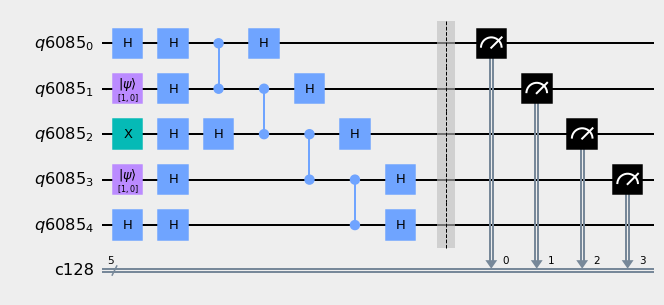

In [823]:
circuit_drawer(phase_circ, output='mpl', style={'backgroundcolor': '#EEEEEE'}, filename='./Images/Circuits/phase_circ.pdf')

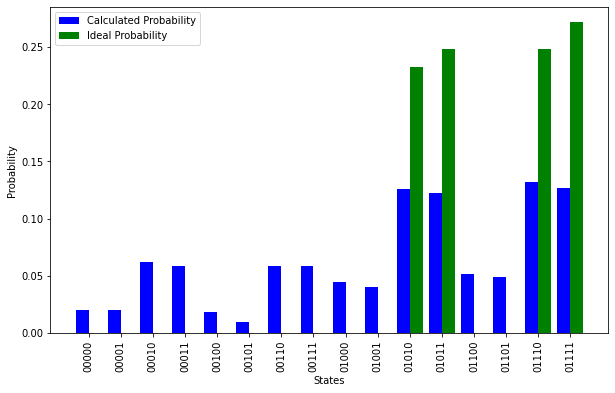

 TVD Distribution
01110
254 135
0.05810546875
01011
254 125
0.12109375
01111
278 130
0.193359375
01010
238 129
0.24658203125
00001
0 21
0.2568359375
00101
0 10
0.26171875
01100
0 53
0.28759765625
00000
0 21
0.2978515625
00011
0 60
0.3271484375
00111
0 60
0.3564453125
01000
0 46
0.37890625
00010
0 64
0.41015625
00100
0 19
0.41943359375
00110
0 60
0.44873046875
01101
0 50
0.47314453125
01001
0 41
0.4931640625
10000
0 0
0.4931640625
10001
0 0
0.4931640625
10010
0 0
0.4931640625
10011
0 0
0.4931640625
10100
0 0
0.4931640625
10101
0 0
0.4931640625
10110
0 0
0.4931640625
10111
0 0
0.4931640625
11000
0 0
0.4931640625
11001
0 0
0.4931640625
11010
0 0
0.4931640625
11011
0 0
0.4931640625
11100
0 0
0.4931640625
11101
0 0
0.4931640625
11110
0 0
0.4931640625
11111
0 0
0.4931640625
Jensen-Shannon Distance
0.7276451351905225
Hellinger Distance
26.617421457152265
26.617421457152265
26.617421457152265


(0.4931640625,
 0.7276451351905225,
 26.617421457152265,
 26.617421457152265,
 26.617421457152265)

In [824]:
bit_error(phase_circ, len(phase_q), 'phase_circ')

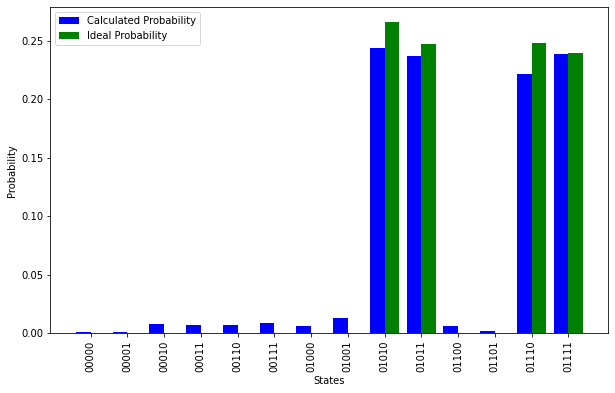

TVD Distribution
01011
253 127
0.0048828125
01111
245 138
0.00537109375
01010
272 137
0.01611328125
01110
254 132
0.029296875
01101
0 46
0.0302734375
00001
0 21
0.03076171875
01100
0 57
0.03369140625
00110
0 45
0.037109375
01000
0 58
0.0400390625
01001
0 57
0.04638671875
00000
0 12
0.046875
00111
0 42
0.05126953125
00011
0 69
0.0546875
00010
0 42
0.05859375
00100
0 24
0.05859375
00101
0 17
0.05859375
10000


KeyError: '10000'

In [825]:
t1_t2(len(phase_q), phase_circ, 'phase_circ')

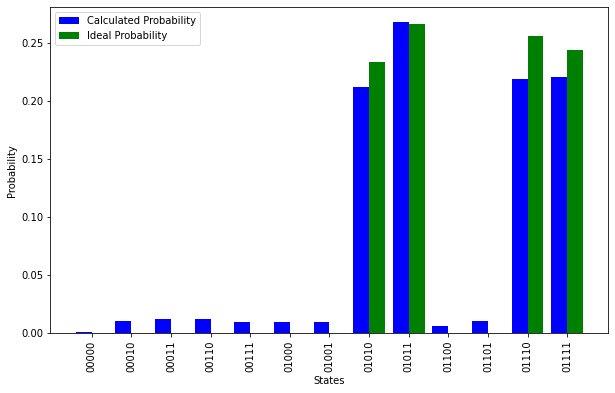

TVD Distribution
01111
250 127
0.06005859375
01011
273 116
0.13671875
01010
239 130
0.18994140625
01110
262 142
0.24853515625
01100
0 46
0.27099609375
01101
0 38
0.28955078125
01001
0 55
0.31640625
00000
0 29
0.33056640625
00111
0 55
0.357421875
00011
0 58
0.3857421875
00110
0 54
0.412109375
00010
0 57
0.43994140625
01000
0 55
0.466796875
00001
0 23
0.47802734375
00100
0 23
0.4892578125
00101
0 16
0.4970703125
10000
0 0
0.4970703125
10001
0 0
0.4970703125
10010
0 0
0.4970703125
10011
0 0
0.4970703125
10100
0 0
0.4970703125
10101
0 0
0.4970703125
10110
0 0
0.4970703125
10111
0 0
0.4970703125
11000
0 0
0.4970703125
11001
0 0
0.4970703125
11010
0 0
0.4970703125
11011
0 0
0.4970703125
11100
0 0
0.4970703125
11101
0 0
0.4970703125
11110
0 0
0.4970703125
11111
0 0
0.4970703125
Jensen-Shannon Distance
0.7001547800816312
Hellinger Distance
25.57742742113534
25.57742742113534
25.57742742113534


(0.4970703125,
 0.7001547800816312,
 25.57742742113534,
 25.57742742113534,
 25.57742742113534)

In [826]:
depolar(len(phase_q), phase_circ, 'phase_circ')

In [827]:
#bit code
bit_q  = QuantumRegister(5)
bit_c = ClassicalRegister(5)
bit_circ = QuantumCircuit(bit_q,bit_c)
bit_circ.barrier()
bit_circ.initialize([1,0], 1)
bit_circ.x(bit_q[2])
bit_circ.initialize([1,0], 3)
bit_circ.barrier()

bit_circ.cx(bit_q[0], bit_q[1])
bit_circ.cx(bit_q[2], bit_q[1])
bit_circ.cx(bit_q[2], bit_q[3])
bit_circ.cx(bit_q[4], bit_q[3])
bit_circ.barrier()
bit_circ.measure(bit_q[0:5],bit_c[0:5])
display(bit_circ.draw())


░                     ░                      ░ ┌─┐            
q6180_0: ─░─────────────────────░───■──────────────────░─┤M├────────────
          ░ ┌─────────────────┐ ░ ┌─┴─┐┌───┐           ░ └╥┘┌─┐         
q6180_1: ─░─┤ Initialize(1,0) ├─░─┤ X ├┤ X ├───────────░──╫─┤M├─────────
          ░ └──────┬───┬──────┘ ░ └───┘└─┬─┘           ░  ║ └╥┘┌─┐      
q6180_2: ─░────────┤ X ├────────░────────■────■────────░──╫──╫─┤M├──────
          ░ ┌──────┴───┴──────┐ ░           ┌─┴─┐┌───┐ ░  ║  ║ └╥┘┌─┐   
q6180_3: ─░─┤ Initialize(1,0) ├─░───────────┤ X ├┤ X ├─░──╫──╫──╫─┤M├───
          ░ └─────────────────┘ ░           └───┘└─┬─┘ ░  ║  ║  ║ └╥┘┌─┐
q6180_4: ─░─────────────────────░──────────────────■───░──╫──╫──╫──╫─┤M├
          ░                     ░                      ░  ║  ║  ║  ║ └╥┘
 c129: 5/═════════════════════════════════════════════════╩══╩══╩══╩══╩═
                                                          0  1  2  3  4

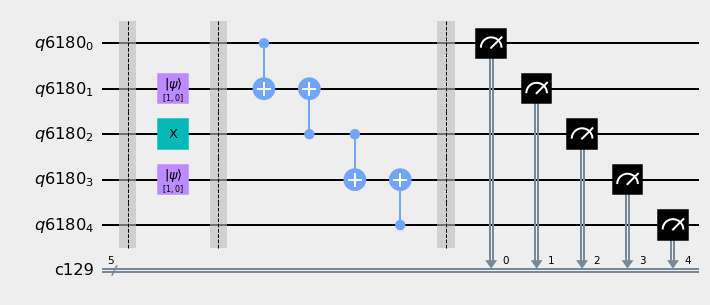

In [828]:
circuit_drawer(bit_circ, output='mpl', style={'backgroundcolor': '#EEEEEE'}, filename='./Images/Circuits/bit_circ.pdf')

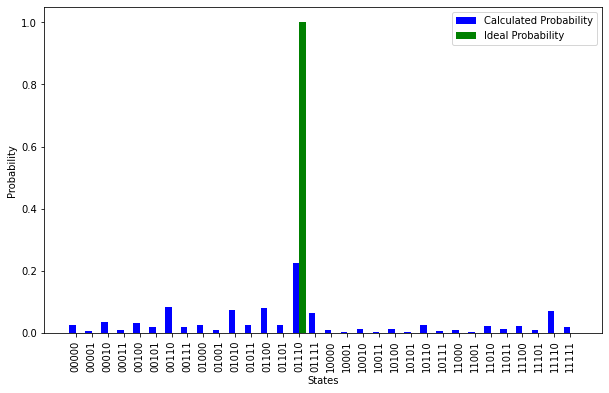

 TVD Distribution
01110
1024 231
0.38720703125
11001
0 4
0.38916015625
10011
0 3
0.390625
11010
0 23
0.40185546875
11000
0 9
0.40625
10111
0 7
0.40966796875
11011
0 13
0.416015625
11101
0 10
0.4208984375
10100
0 13
0.42724609375
10101
0 3
0.4287109375
10000
0 8
0.4326171875
00110
0 87
0.47509765625
00011
0 9
0.4794921875
00100
0 33
0.49560546875
01011
0 25
0.5078125
00000
0 25
0.52001953125
00111
0 18
0.52880859375
11100
0 23
0.5400390625
11110
0 71
0.57470703125
00010
0 37
0.5927734375
10001
0 4
0.5947265625
01010
0 76
0.6318359375
01111
0 66
0.6640625
11111
0 18
0.6728515625
10110
0 26
0.685546875
10010
0 14
0.6923828125
01000
0 26
0.705078125
01001
0 10
0.7099609375
00101
0 19
0.71923828125
01100
0 82
0.75927734375
00001
0 6
0.76220703125
01101
0 25
0.7744140625
Jensen-Shannon Distance
0.8248392698725042
Hellinger Distance
30.983866769659333
30.983866769659333
30.983866769659333


(0.7744140625,
 0.8248392698725042,
 30.983866769659333,
 30.983866769659333,
 30.983866769659333)

In [829]:
bit_error(bit_circ, len(bit_q), 'bit_circ')

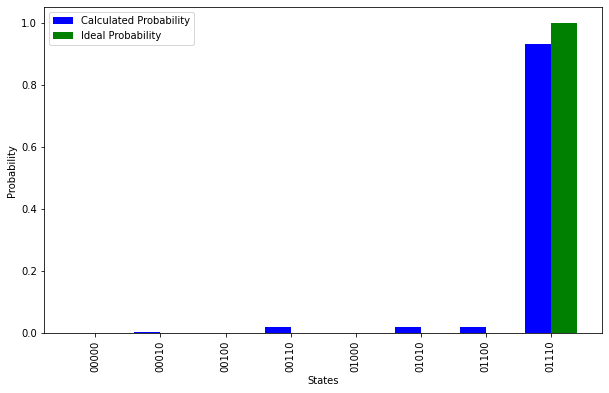

TVD Distribution
01110
1024 209
0.0341796875
00010
0 41
0.03564453125
01000
0 36
0.0361328125
01010
0 62
0.046875
01100
0 86
0.05615234375
00100
0 39
0.05712890625
00110
0 107
0.0673828125
00000
0 27
0.068359375
00001
0 4
0.068359375
00011
0 17
0.068359375
00101
0 10
0.068359375
00111
0 26
0.068359375
01001
0 9
0.068359375
01011
0 18
0.068359375
01101
0 23
0.068359375
01111
0 73
0.068359375
10000
0 6
0.068359375
10001
0 2
0.068359375
10010
0 13
0.068359375
10011
0 1
0.068359375
10100
0 11
0.068359375
10101
0 1
0.068359375
10110
0 34
0.068359375
10111
0 2
0.068359375
11000
0 10
0.068359375
11001
0 4
0.068359375
11010
0 30
0.068359375
11011
0 2
0.068359375
11100
0 18
0.068359375
11101
0 7
0.068359375
11110
0 80
0.068359375
11111
0 16
0.068359375
Jensen-Shannon Distance
0.8265203961954842
Hellinger Distance
31.12192754566779
31.12192754566779
31.1219275456678


(0.068359375,
 0.8265203961954842,
 31.12192754566779,
 31.12192754566779,
 31.1219275456678)

In [830]:
t1_t2(len(bit_q), bit_circ, 'bit_circ')

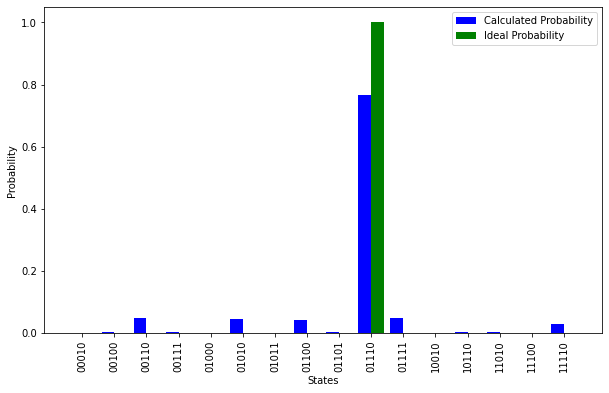

TVD Distribution
01110
1024 229
0.38818359375
01000
0 42
0.40869140625
10010
0 9
0.4130859375
01011
0 22
0.423828125
00111
0 33
0.43994140625
10110
0 20
0.44970703125
00010
0 42
0.47021484375
11110
0 60
0.49951171875
11100
0 28
0.51318359375
01101
0 27
0.5263671875
11010
0 16
0.5341796875
01100
0 86
0.576171875
00100
0 50
0.6005859375
00110
0 98
0.6484375
01111
0 58
0.6767578125
01010
0 73
0.71240234375
00000
0 15
0.7197265625
00001
0 10
0.724609375
00011
0 7
0.72802734375
00101
0 10
0.73291015625
01001
0 9
0.7373046875
10000
0 5
0.73974609375
10001
0 1
0.740234375
10011
0 3
0.74169921875
10100
0 10
0.74658203125
10101
0 2
0.74755859375
10111
0 11
0.7529296875
11000
0 8
0.7568359375
11001
0 4
0.7587890625
11011
0 5
0.76123046875
11101
0 9
0.765625
11111
0 22
0.7763671875
Jensen-Shannon Distance
0.8187016966724694
Hellinger Distance
30.553074018961194
30.553074018961194
30.553074018961194


(0.7763671875,
 0.8187016966724694,
 30.553074018961194,
 30.553074018961194,
 30.553074018961194)

In [831]:
depolar(len(bit_q), bit_circ, 'bit_circ')

In [832]:
swap_qaoa_q = QuantumRegister(4)
swap_qaoa_c = ClassicalRegister(4)
swap_qaoa_circ = QuantumCircuit(swap_qaoa_q, swap_qaoa_c)
swap_qaoa_circ.h(swap_qaoa_q[0:4])
swap_qaoa_circ.cx(swap_qaoa_q[0], swap_qaoa_q[1])
swap_qaoa_circ.cx(swap_qaoa_q[2], swap_qaoa_q[3])
swap_qaoa_circ.rz(np.pi/2, 1)
swap_qaoa_circ.rz(np.pi/2, 2)
swap_qaoa_circ.cx(swap_qaoa_q[1], swap_qaoa_q[0])
swap_qaoa_circ.cx(swap_qaoa_q[3], swap_qaoa_q[2])
swap_qaoa_circ.cx(swap_qaoa_q[0], swap_qaoa_q[1])
swap_qaoa_circ.cx(swap_qaoa_q[2], swap_qaoa_q[3])
swap_qaoa_circ.cx(swap_qaoa_q[1], swap_qaoa_q[2])
swap_qaoa_circ.rz(np.pi/2, 3)
swap_qaoa_circ.cx(swap_qaoa_q[2], swap_qaoa_q[1])
swap_qaoa_circ.cx(swap_qaoa_q[1], swap_qaoa_q[2])
swap_qaoa_circ.cx(swap_qaoa_q[0], swap_qaoa_q[1])
swap_qaoa_circ.cx(swap_qaoa_q[2], swap_qaoa_q[3])
swap_qaoa_circ.rz(np.pi/2, 1)
swap_qaoa_circ.rz(np.pi/2, 3)
swap_qaoa_circ.cx(swap_qaoa_q[1], swap_qaoa_q[0])
swap_qaoa_circ.cx(swap_qaoa_q[3], swap_qaoa_q[2])
swap_qaoa_circ.cx(swap_qaoa_q[0], swap_qaoa_q[1])
swap_qaoa_circ.cx(swap_qaoa_q[2], swap_qaoa_q[3])
swap_qaoa_circ.cx(swap_qaoa_q[1], swap_qaoa_q[2])
swap_qaoa_circ.rz(np.pi/2, 2)
swap_qaoa_circ.cx(swap_qaoa_q[2], swap_qaoa_q[1])
swap_qaoa_circ.cx(swap_qaoa_q[1], swap_qaoa_q[2])
swap_qaoa_circ.rz(np.pi/3, 0)
swap_qaoa_circ.rz(np.pi/3, 1)
swap_qaoa_circ.rz(np.pi/3, 2)
swap_qaoa_circ.rz(np.pi/3, 3)
swap_qaoa_circ.barrier()
swap_qaoa_circ.measure(swap_qaoa_q[0:4], swap_qaoa_c[0:4])
display(swap_qaoa_circ.draw())


┌───┐                ┌───┐                                          »
q6256_0: ┤ H ├──■─────────────┤ X ├──■─────────────────────────■─────────────»
         ├───┤┌─┴─┐┌─────────┐└─┬─┘┌─┴─┐           ┌───┐     ┌─┴─┐┌─────────┐»
q6256_1: ┤ H ├┤ X ├┤ Rz(π/2) ├──■──┤ X ├─────■─────┤ X ├──■──┤ X ├┤ Rz(π/2) ├»
         ├───┤└───┘├─────────┤┌───┐└───┘   ┌─┴─┐   └─┬─┘┌─┴─┐└───┘└─────────┘»
q6256_2: ┤ H ├──■──┤ Rz(π/2) ├┤ X ├──■─────┤ X ├─────■──┤ X ├──■─────────────»
         ├───┤┌─┴─┐└─────────┘└─┬─┘┌─┴─┐┌──┴───┴──┐     └───┘┌─┴─┐┌─────────┐»
q6256_3: ┤ H ├┤ X ├─────────────■──┤ X ├┤ Rz(π/2) ├──────────┤ X ├┤ Rz(π/2) ├»
         └───┘└───┘                └───┘└─────────┘          └───┘└─────────┘»
 c130: 4/════════════════════════════════════════════════════════════════════»
                                                                             »
«         ┌───┐     ┌─────────┐                                 ░ ┌─┐         
«q6256_0: ┤ X ├──■──┤ Rz(π/3) ├─────────────────────────────────░─┤M├─────────
«         └─┬─┘┌─┴─┐└─────────┘           ┌───┐     ┌─────────┐ ░ └╥┘┌─┐      
«q6256_1: ──■──┤ X ├─────■────────────────┤ X ├──■──┤ Rz(π/3) ├─░──╫─┤M├──────
«         ┌───┐└───┘   ┌─┴─┐   ┌─────────┐└─┬─┘┌─┴─┐├─────────┤ ░  ║ └╥┘┌─┐   
«q6256_2: ┤ X ├──■─────┤ X ├───┤ Rz(π/2) ├──■──┤ X ├┤ Rz(π/3) ├─░──╫──╫─┤M├───
«         └─┬─┘┌─┴─┐┌──┴───┴──┐└─────────┘     └───┘└─────────┘ ░  ║  ║ └╥┘┌─┐
«q6256_3: ──■──┤ X ├┤ Rz(π/3) ├─────────────────────────────────░──╫──╫──╫─┤M├
«              └───┘└─────────┘                                 ░  ║  ║  ║ └╥┘
« c130: 4/═════════════════════════════════════════════════════════╩══╩══╩══╩═
«                                                                  0  1  2  3

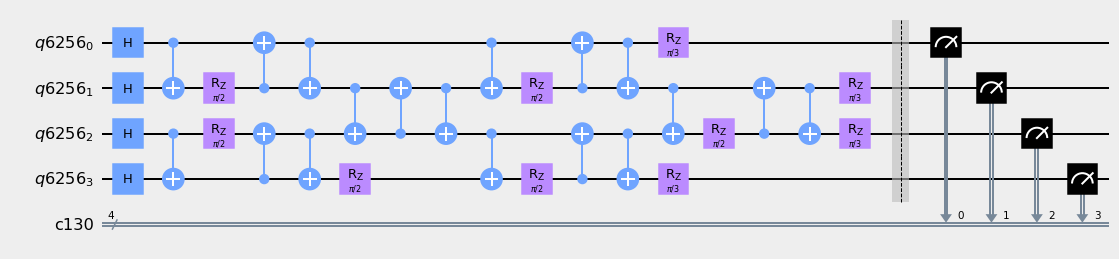

In [833]:
circuit_drawer(swap_qaoa_circ, output='mpl', style={'backgroundcolor': '#EEEEEE'}, filename='./Images/Circuits/swap_qaoa_circ.pdf')

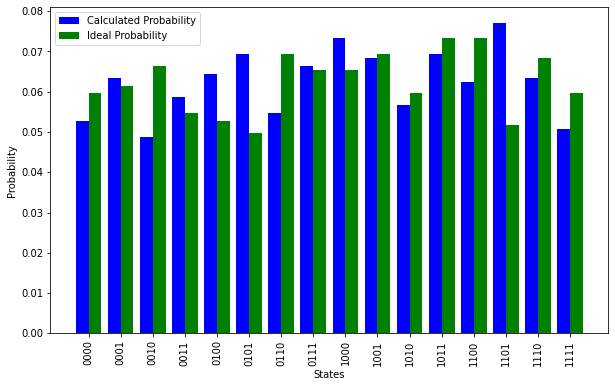

 TVD Distribution
1110
70 65
0.00244140625
1011
75 71
0.00439453125
1101
53 79
0.01708984375
0001
63 65
0.01806640625
1010
61 58
0.01953125
1111
61 52
0.02392578125
1000
67 75
0.02783203125
0010
68 50
0.03662109375
0110
71 56
0.0439453125
0100
54 66
0.0498046875
0111
67 68
0.05029296875
0000
61 54
0.0537109375
0011
56 60
0.0556640625
1001
71 70
0.05615234375
0101
51 71
0.06591796875
1100
75 64
0.0712890625
Jensen-Shannon Distance
0.06427713136927665
Hellinger Distance
2.058446562495172
2.058446562495172
2.058446562495172


(0.0712890625,
 0.06427713136927665,
 2.058446562495172,
 2.058446562495172,
 2.058446562495172)

In [834]:
bit_error(swap_qaoa_circ, len(swap_qaoa_q), 'swap_qaoa')

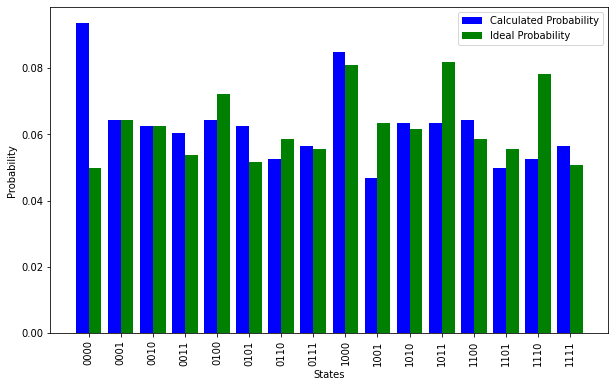

TVD Distribution
1101
57 56
0.0029296875
0001
66 56
0.0029296875
1110
80 58
0.015625
1011
84 67
0.02490234375
0101
53 77
0.0302734375
1100
60 71
0.033203125
1111
52 77
0.0361328125
1010
63 62
0.037109375
1000
83 67
0.0390625
1001
65 68
0.04736328125
0111
57 64
0.0478515625
0011
55 54
0.05126953125
0000
51 55
0.0732421875
0010
64 66
0.0732421875
0110
60 72
0.076171875
0100
74 54
0.080078125
Jensen-Shannon Distance
0.09506843812350321
Hellinger Distance
3.047329938295048
3.047329938295048
3.047329938295048


(0.080078125,
 0.09506843812350321,
 3.047329938295048,
 3.047329938295048,
 3.047329938295048)

In [835]:
t1_t2(len(swap_qaoa_q), swap_qaoa_circ, 'swap_qaoa')

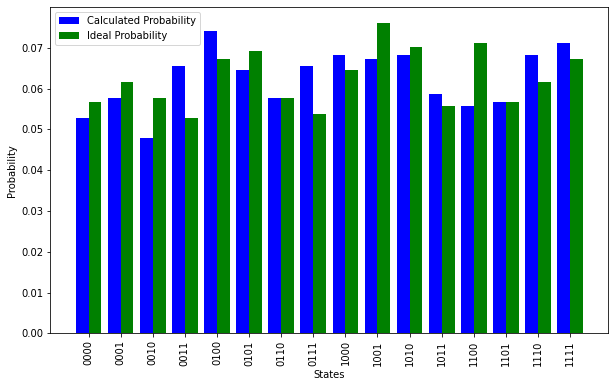

TVD Distribution
1011
57 67
0.0048828125
0001
63 69
0.0078125
1110
63 61
0.0087890625
1000
66 64
0.009765625
0111
55 63
0.013671875
0000
58 73
0.02099609375
0011
54 61
0.0244140625
0010
59 69
0.029296875
1101
58 73
0.03662109375
0100
69 60
0.041015625
0110
59 65
0.0439453125
1001
78 59
0.05322265625
1010
72 65
0.056640625
1111
69 49
0.06640625
1100
73 73
0.06640625
0101
71 53
0.0751953125
Jensen-Shannon Distance
0.05591039749292874
Hellinger Distance
1.7914552281789928
1.7914552281789928
1.7914552281789928


(0.0751953125,
 0.05591039749292874,
 1.7914552281789928,
 1.7914552281789928,
 1.7914552281789928)

In [836]:
depolar(len(swap_qaoa_q), swap_qaoa_circ, 'swap_qaoa')

In [837]:
vanilla_qaoa_q = QuantumRegister(3)
vanilla_qaoa_c = ClassicalRegister(3)
vanilla_qaoa_circ = QuantumCircuit(vanilla_qaoa_q, vanilla_qaoa_c)
vanilla_qaoa_circ.h(vanilla_qaoa_q[0:3])
vanilla_qaoa_circ.cx(vanilla_qaoa_q[0], vanilla_qaoa_q[1])
vanilla_qaoa_circ.rz(np.pi/2, 1)
vanilla_qaoa_circ.cx(vanilla_qaoa_q[0], vanilla_qaoa_q[1])
vanilla_qaoa_circ.cx(vanilla_qaoa_q[0], vanilla_qaoa_q[2])
vanilla_qaoa_circ.rz(np.pi/2, 2)
vanilla_qaoa_circ.cx(vanilla_qaoa_q[0], vanilla_qaoa_q[2])
vanilla_qaoa_circ.cx(vanilla_qaoa_q[1], vanilla_qaoa_q[2])
vanilla_qaoa_circ.rz(np.pi/2, 2)
vanilla_qaoa_circ.cx(vanilla_qaoa_q[1], vanilla_qaoa_q[2])
vanilla_qaoa_circ.rz(np.pi/3, 0)
vanilla_qaoa_circ.rz(np.pi/3, 1)
vanilla_qaoa_circ.rz(np.pi/3, 2)
vanilla_qaoa_circ.barrier()
vanilla_qaoa_circ.measure(vanilla_qaoa_q[0:3], vanilla_qaoa_c[0:3])
display(vanilla_qaoa_circ.draw())

┌───┐                                          ┌─────────┐           »
q6317_0: ┤ H ├──■───────────────■────■───────────────■──┤ Rz(π/3) ├───────────»
         ├───┤┌─┴─┐┌─────────┐┌─┴─┐  │               │  └─────────┘           »
q6317_1: ┤ H ├┤ X ├┤ Rz(π/2) ├┤ X ├──┼───────────────┼───────■────────────────»
         ├───┤└───┘└─────────┘└───┘┌─┴─┐┌─────────┐┌─┴─┐   ┌─┴─┐   ┌─────────┐»
q6317_2: ┤ H ├─────────────────────┤ X ├┤ Rz(π/2) ├┤ X ├───┤ X ├───┤ Rz(π/2) ├»
         └───┘                     └───┘└─────────┘└───┘   └───┘   └─────────┘»
 c131: 3/═════════════════════════════════════════════════════════════════════»
                                                                              »
«                          ░ ┌─┐      
«q6317_0: ─────────────────░─┤M├──────
«              ┌─────────┐ ░ └╥┘┌─┐   
«q6317_1: ──■──┤ Rz(π/3) ├─░──╫─┤M├───
«         ┌─┴─┐├─────────┤ ░  ║ └╥┘┌─┐
«q6317_2: ┤ X ├┤ Rz(π/3) ├─░──╫──╫─┤M├
«         └───┘└─────────┘ ░  ║  ║ └╥┘
« c131: 3/════════════════════╩══╩══╩═
«                             0  1  2

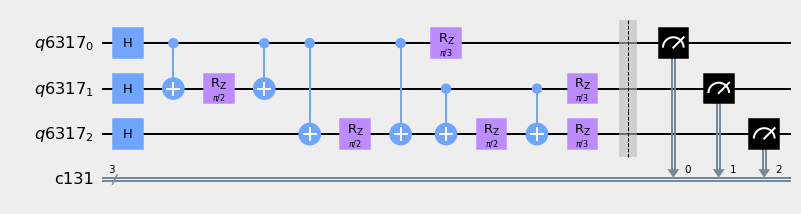

In [838]:
circuit_drawer(vanilla_qaoa_circ, output='mpl', style={'backgroundcolor': '#EEEEEE'}, filename='./Images/Circuits/vanilla_qaoa_circ.pdf')

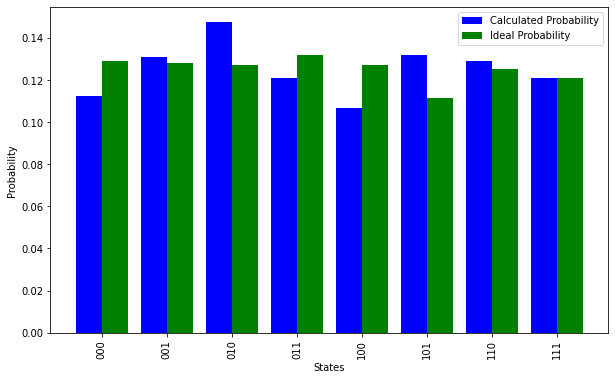

 TVD Distribution
101
114 135
0.01025390625
001
131 134
0.01171875
010
130 151
0.02197265625
000
132 115
0.0302734375
011
135 124
0.03564453125
111
124 124
0.03564453125
110
128 132
0.03759765625
100
130 109
0.0478515625
Jensen-Shannon Distance
0.04136142767316674
Hellinger Distance
1.323908778779863
1.323908778779863
1.323908778779863


(0.0478515625,
 0.04136142767316674,
 1.323908778779863,
 1.323908778779863,
 1.323908778779863)

In [839]:
bit_error(vanilla_qaoa_circ, len(vanilla_qaoa_q), 'vanilla_qaoa')

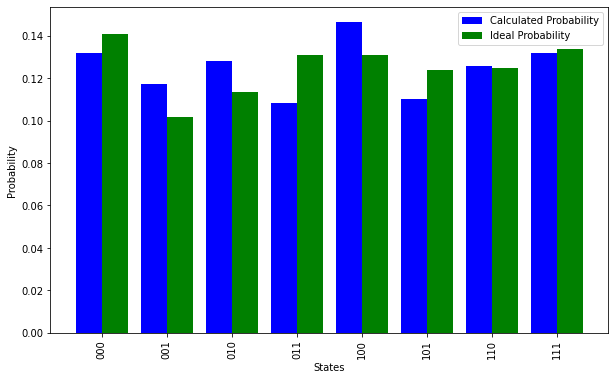

TVD Distribution
111
137 125
0.0009765625
000
144 150
0.00537109375
011
134 137
0.0166015625
010
116 121
0.02392578125
100
134 122
0.03173828125
110
128 127
0.0322265625
001
104 126
0.0400390625
101
127 116
0.046875
Jensen-Shannon Distance
0.04829747666499302
Hellinger Distance
1.5462061051625218
1.5462061051625218
1.5462061051625218


(0.046875,
 0.04829747666499302,
 1.5462061051625218,
 1.5462061051625218,
 1.5462061051625218)

In [840]:
t1_t2(len(vanilla_qaoa_q), vanilla_qaoa_circ, 'vanilla_qaoa')

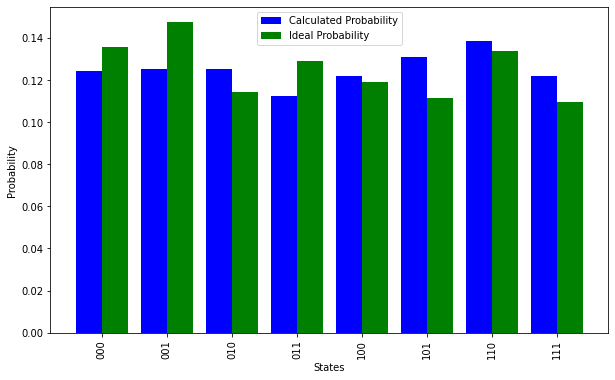

TVD Distribution
101
114 123
0.00439453125
010
117 136
0.013671875
111
112 121
0.01806640625
000
139 131
0.02197265625
011
132 145
0.0283203125
110
137 128
0.03271484375
100
122 122
0.03271484375
001
151 118
0.048828125
Jensen-Shannon Distance
0.0482208229078535
Hellinger Distance
1.5436338329395725
1.5436338329395725
1.5436338329395725


(0.048828125,
 0.0482208229078535,
 1.5436338329395725,
 1.5436338329395725,
 1.5436338329395725)

In [841]:
depolar(len(vanilla_qaoa_q), vanilla_qaoa_circ, 'vanilla_qaoa')

In [842]:
hamilton_q = QuantumRegister(3)
hamilton_c = ClassicalRegister(3)
hamilton_circ = QuantumCircuit(hamilton_q, hamilton_c)
hamilton_circ.h(hamilton_q[0:4])
hamilton_circ.rz(np.pi/2, hamilton_q[0:4])
hamilton_circ.h(hamilton_q[0:4])
hamilton_circ.cx(hamilton_q[0], hamilton_q[1])
hamilton_circ.rz(np.pi/3, 1)
hamilton_circ.cx(hamilton_q[0], hamilton_q[1])
hamilton_circ.cx(hamilton_q[1], hamilton_q[2])
hamilton_circ.rz(np.pi/3, 2)
hamilton_circ.cx(hamilton_q[1], hamilton_q[2])
hamilton_circ.barrier()
hamilton_circ.measure(hamilton_q[0:3], hamilton_c[0:3])
display(hamilton_circ.draw())

┌───┐┌─────────┐┌───┐                                           ░ ┌─┐»
q6378_0: ┤ H ├┤ Rz(π/2) ├┤ H ├──■───────────────■────────────────────────░─┤M├»
         ├───┤├─────────┤├───┤┌─┴─┐┌─────────┐┌─┴─┐                      ░ └╥┘»
q6378_1: ┤ H ├┤ Rz(π/2) ├┤ H ├┤ X ├┤ Rz(π/3) ├┤ X ├──■───────────────■───░──╫─»
         ├───┤├─────────┤├───┤└───┘└─────────┘└───┘┌─┴─┐┌─────────┐┌─┴─┐ ░  ║ »
q6378_2: ┤ H ├┤ Rz(π/2) ├┤ H ├─────────────────────┤ X ├┤ Rz(π/3) ├┤ X ├─░──╫─»
         └───┘└─────────┘└───┘                     └───┘└─────────┘└───┘ ░  ║ »
 c132: 3/═══════════════════════════════════════════════════════════════════╩═»
                                                                            0 »
«               
«q6378_0: ──────
«         ┌─┐   
«q6378_1: ┤M├───
«         └╥┘┌─┐
«q6378_2: ─╫─┤M├
«          ║ └╥┘
« c132: 3/═╩══╩═
«          1  2

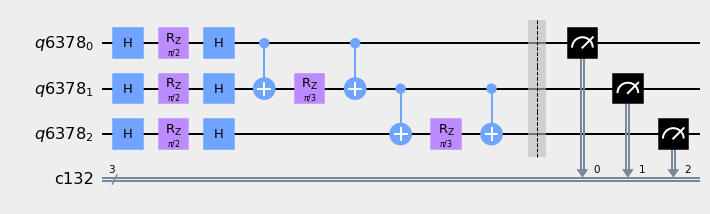

In [843]:
circuit_drawer(hamilton_circ, output='mpl', style={'backgroundcolor': '#EEEEEE'}, filename='./Images/Circuits/hamilton_circ.pdf')

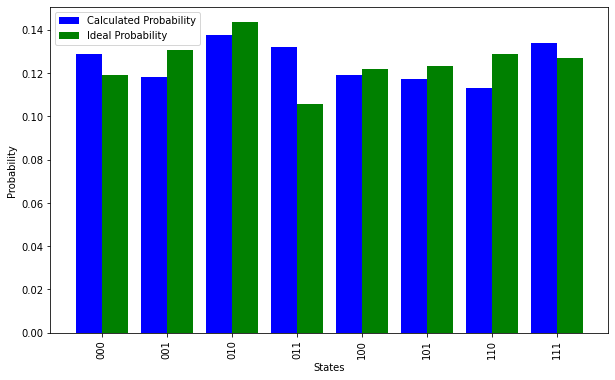

 TVD Distribution
011
108 135
0.01318359375
000
122 132
0.01806640625
111
130 137
0.021484375
100
125 122
0.02294921875
110
132 116
0.03076171875
010
147 141
0.03369140625
001
134 121
0.0400390625
101
126 120
0.04296875
Jensen-Shannon Distance
0.02598827084191154
Hellinger Distance
0.8317242190058916
0.8317242190058916
0.8317242190058916


(0.04296875,
 0.02598827084191154,
 0.8317242190058916,
 0.8317242190058916,
 0.8317242190058916)

In [844]:
bit_error(hamilton_circ, len(hamilton_q), 'hamilton_circ')

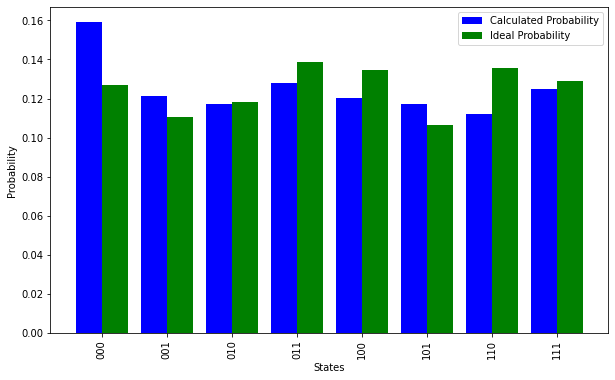

TVD Distribution
101
109 130
0.00537109375
001
113 101
0.0107421875
100
138 138
0.01806640625
110
139 129
0.02978515625
010
121 136
0.0302734375
011
142 137
0.03564453125
000
130 135
0.0517578125
111
132 118
0.0537109375
Jensen-Shannon Distance
0.03901063857307048
Hellinger Distance
1.2486541780654488
1.2486541780654488
1.2486541780654488


(0.0537109375,
 0.03901063857307048,
 1.2486541780654488,
 1.2486541780654488,
 1.2486541780654488)

In [845]:
t1_t2(len(hamilton_q), hamilton_circ, 'hamilton_circ')

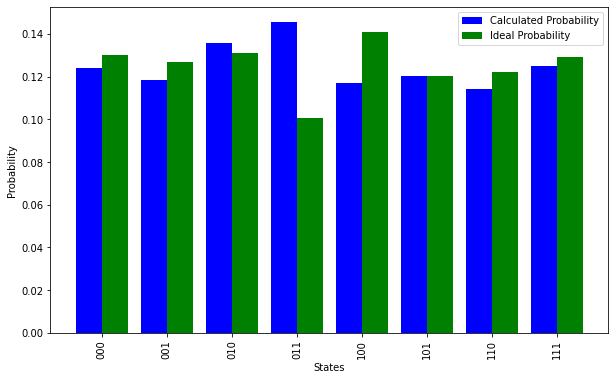

TVD Distribution
100
144 140
0.001953125
110
125 122
0.00341796875
010
134 153
0.0126953125
001
130 126
0.0146484375
101
123 125
0.015625
000
133 133
0.015625
111
132 115
0.02392578125
011
103 110
0.02734375
Jensen-Shannon Distance
0.05180475223142366
Hellinger Distance
1.6587834841616733
1.6587834841616733
1.6587834841616733


(0.02734375,
 0.05180475223142366,
 1.6587834841616733,
 1.6587834841616733,
 1.6587834841616733)

In [846]:
depolar(len(hamilton_q), hamilton_circ, 'hamilton_circ')